<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation

Why do we need robust model evaluation?

A forecast is like an experiment -- given a set of conditions, we make a hypothesis that a certain outcome will occur.

We wouldn't consider an experiment to be complete until we determined its outcome; i.e., we need to find out whether the forecast was successful.

Notebook content below is based on the 2024 AMS Annual Meeting AI for Environmental Science Short Course. Evaluation session taught by Hamid Kamangir (University of California, Davis).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
import sklearn.model_selection as model_selection
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
#precent auto-scrolling
#The next cell prevents output in the notebook from being nested in a scroll box
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;

<IPython.core.display.Javascript object>

### Let's do a case study application for evaluation

We will use a dataset from an American Meteorological Society AI for Environmental Science short course held in January 2024 in Baltimore, MD.

In [3]:
# dataset for nb
! wget https://raw.github.com/ekrell/ams_ai_shortcourse_2024/main/data/kdfw_processed_sub_data.csv

--2024-04-18 16:05:47--  https://raw.github.com/ekrell/ams_ai_shortcourse_2024/main/data/kdfw_processed_sub_data.csv
Resolving raw.github.com (raw.github.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/main/data/kdfw_processed_sub_data.csv [following]
--2024-04-18 16:05:47--  https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/main/data/kdfw_processed_sub_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4400996 (4.2M) [text/plain]
Saving to: ‘kdfw_processed_sub_data.csv.5’

kdfw_processed_sub_ 100%[==========

In [4]:
# open csv dataset and do some preprocessing
total_dataset = pd.read_csv('kdfw_processed_sub_data.csv', index_col=0).sort_values(by='date') ##kdfw - Dallas-Ft Worth, TX
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf, np.nan).dropna(how='any',axis=1)
total_dataset.head(5)

,date,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour,GFS0_pmsl_max,GFS0_pmsl_min,GFS0_pmsl_avg,GFS0_pres_max,GFS0_pres_min,...,GFS0_qpf_accum_avg,GFS0_wagl_max,GFS0_wagl_min,GFS0_wagl_avg,GFS0_frz_rain_max,GFS0_frz_rain_min,GFS0_frz_rain_avg,GFS0_sleet_max,GFS0_sleet_min,GFS0_sleet_avg
0,2011-01-01,44.06,30.02,14.0,0.0,1026.3,1015.1,1022.640000,1004.4,993.2,...,0.000000,15.485419,3.578924,10.642520,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-02,48.02,24.98,7.0,0.0,1029.5,1024.7,1026.938889,1007.6,1003.1,...,0.000000,14.324710,3.371784,7.165481,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-03,57.92,30.92,18.0,0.0,1025.3,1017.1,1021.183333,1003.6,995.6,...,0.000000,19.368173,11.727873,15.322729,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-04,55.94,41.00,8.0,0.0,1022.6,1016.0,1018.912500,1001.0,994.5,...,0.001148,17.630049,0.935607,7.547890,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-05,57.92,35.96,12.0,0.0,1019.5,1014.8,1016.875000,997.8,993.0,...,0.002297,14.434982,2.635952,10.020610,0.0,0.0,0.0,0.0,0.0,0.0


### Regression

Let's set up a regression problem for evaluation.

In [5]:
#first, we seperate the observation (true value) from the features/predictors
#Observation data
total_label_data = total_dataset.filter(like='OBS')

#remove obs data and date from the feature set
dropCols = list(total_label_data.columns) # + ['date']
total_feature_data = total_dataset.copy(deep=True)
total_feature_data = total_feature_data.drop(dropCols,axis=1)

#look at the shape of each array again
print(total_dataset.shape)
print(total_label_data.shape)
print(total_label_data.columns)
print(total_feature_data.shape)
print(total_feature_data.columns)

(3143, 200)
(3143, 4)
Index(['OBS_tmpf_max', 'OBS_tmpf_min', 'OBS_sknt_max', 'OBS_phour'], dtype='object')
(3143, 196)
Index(['date', 'GFS0_pmsl_max', 'GFS0_pmsl_min', 'GFS0_pmsl_avg',
       'GFS0_pres_max', 'GFS0_pres_min', 'GFS0_pres_avg', 'GFS0_sktc_max',
       'GFS0_sktc_min', 'GFS0_sktc_avg',
       ...
       'GFS0_qpf_accum_avg', 'GFS0_wagl_max', 'GFS0_wagl_min', 'GFS0_wagl_avg',
       'GFS0_frz_rain_max', 'GFS0_frz_rain_min', 'GFS0_frz_rain_avg',
       'GFS0_sleet_max', 'GFS0_sleet_min', 'GFS0_sleet_avg'],
      dtype='object', length=196)


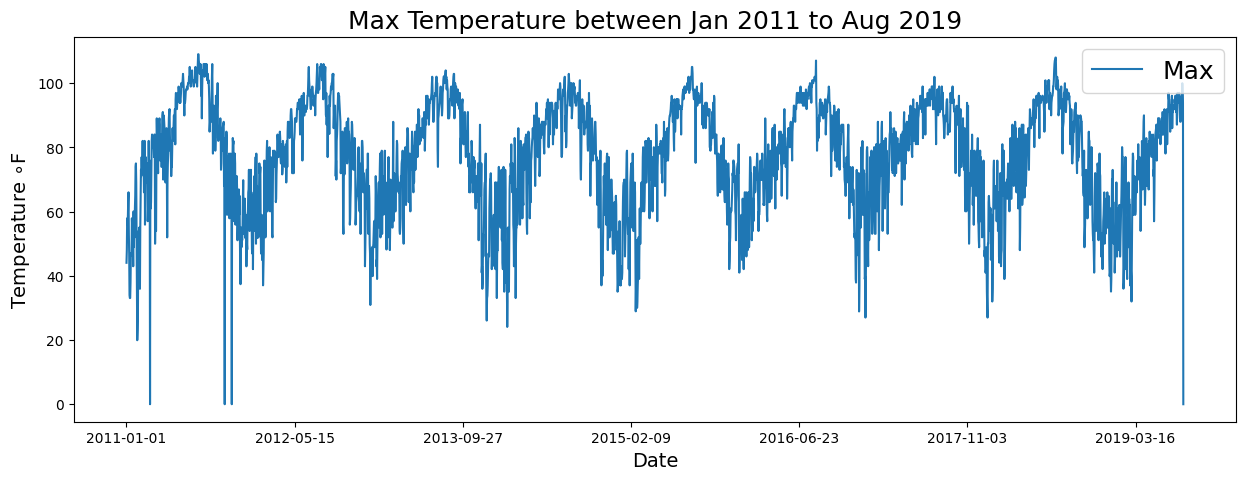

In [6]:
# visualization
fig, ax = plt.subplots(figsize=(15, 5))

labels = total_dataset['date'].values
data_label_pair = [('Max', total_label_data['OBS_tmpf_max'])]

for label, temp in data_label_pair:
  plt.plot(np.arange(len(labels)), temp, label=label)

ax.set_xticks(np.arange(len(labels))[::500])
ax.set_xticklabels(labels[::500])
plt.ylabel("Temperature $\circ$F",fontsize=14)
plt.xlabel("Date",fontsize=14)
plt.legend(loc='upper right',fontsize=18)
plt.title('Max Temperature between Jan 2011 to Aug 2019', fontsize=18)
plt.show()

In [7]:
# For now, let's try with only 50 features from GFS model
subsample_feature = total_feature_data.iloc[:,:51] #date + 50 features

# we only need maximum temperature from obs
subsample_label = total_label_data['OBS_tmpf_max'][:]

In [8]:
def scale_data(train_x, test_x):
    """
    Scales training and testing data using MinMaxScaler.

    Parameters:
    train_x (array-like): Training data features.
    test_x (array-like): Testing data features.

    Returns:
    tuple: Scaled training and testing data.
    """

    # Fit/find minimum and maximum value for each input variable
    min_max_model = MinMaxScaler().fit(train_x)

    # This saves the values to apply or 'transform' testing data
    train_x_minmax = min_max_model.transform(train_x)
    #print('Training data range \nMax:', np.nanmax(train_x_minmax), ', Min:', np.nanmin(train_x_minmax))

    # Apply the min/max values to testing data
    test_x_minmax = min_max_model.transform(test_x)
    #print('\nTesting data range \nMax:', np.nanmax(test_x_minmax), ', Min:', np.nanmin(test_x_minmax))

    return train_x_minmax, test_x_minmax

def split_data_by_date(features, labels, date_ranges):
    """
    Splits a DataFrame into multiple DataFrames based on specified date ranges.

    Args:
    df (pd.DataFrame): The original DataFrame.
    time_col (str): The name of the column containing time data.
    date_ranges (list of tuples): A list of tuples where each tuple contains start and end dates as strings.
                                  Example: [('2009-01-01', '2012-12-31'), ('2013-01-01', '2017-12-31')]

    Returns:
    list: A list containing the split DataFrames.
    """

    features_list = pd.to_datetime(features['date'])
    date_mask = (features_list > date_ranges[0]) & (features_list <= date_ranges[1])
    out_data = features.loc[date_mask,:].drop(['date'], axis=1)
    out_labels = labels.loc[date_mask]

    return out_data, out_labels

In [9]:
date_ranges = [('2011-01-01','2017-12-31'), ('2018-01-01','2019-12-31')]
time_train_x, time_train_y = split_data_by_date(subsample_feature, subsample_label,  date_ranges[0])
time_test_x, time_test_y = split_data_by_date(subsample_feature, subsample_label, date_ranges[1])
print(f"train dataset samples: {time_train_x.shape} | test dataset samples: {time_test_x.shape}")

train dataset samples: (2558, 50) | test dataset samples: (583, 50)


In [10]:
scaled_time_train_x, scaled_time_test_x = scale_data(time_train_x, time_test_x)

##### Mean Absolute Error (MAE)
This metric measures the average of the absolute differences between the predicted and actual values. **It gives equal weight to all errors and is less sensitive to outliers.**

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

##### R^2

This metric measures the proportion of variance in the target variable explained by the model. It ranges from 0 to 1, with higher values indicating better performance. R2 is useful when the goal is to explain the variability in the target variable using the predictors.

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

In [11]:
# Train and evaluate the model to predict max temperature
linear_regression_model = LinearRegression()
# Train
linear_regression_model.fit(scaled_time_train_x, time_train_y.values)

# score on training set
train_y_pred = linear_regression_model.predict(scaled_time_train_x)
R2 = sklearn.metrics.r2_score(time_train_y.values, train_y_pred)
MAE = sklearn.metrics.mean_absolute_error(time_train_y.values, train_y_pred)
print(f"Train Evaluation =========>  R^2 = {R2:.2f} | MAE = {MAE:.2f}")

# score on testing set
test_y_pred = linear_regression_model.predict(scaled_time_test_x)
R2_test = sklearn.metrics.r2_score(time_test_y.values, test_y_pred)
MAE_test = sklearn.metrics.mean_absolute_error(time_test_y.values, test_y_pred)
print(f"Test Evaluation  =========>  R^2 = {R2_test:.2f} | MAE = {MAE_test:.2f}")

Train Evaluation =========>  R^2 = 0.93 | MAE = 3.18
Test Evaluation  =========>  R^2 = 0.85 | MAE = 4.47


In [12]:
def scatter_plot(ytrue, ypred):

    R2 = sklearn.metrics.r2_score(ytrue, ypred)
    MAE = sklearn.metrics.mean_absolute_error(ytrue, ypred)

    g = sns.jointplot(x = ytrue,
                        y = ypred,
                        height = 6,
                        ratio = 3)

    g.ax_joint.plot([0, 110], [0, 110], '--r', linewidth=2)

    plt.xlabel('Measured (F)')
    plt.ylabel('Predicted (F)')
    plt.grid(False)

    scores = (r'R^2={:.2f}' + '\n' + r'MAE={:.2f}' + '\n').format(
        R2, MAE)

    plt.text(1, 115.7, scores, bbox=dict(facecolor = 'white', edgecolor = 'gray', boxstyle = 'round, pad=0.2'),
            fontsize = 12, ha='left', va = 'top')
    plt.show()

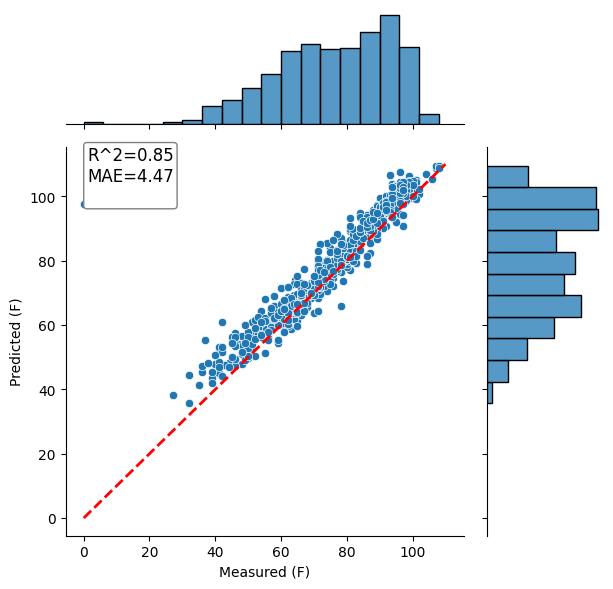

In [13]:
scatter_plot(time_test_y, test_y_pred)

### Classification

We can convert our continuous values to binary classes.

## Common classification evaluation

##### Confusion Matrix

<figure>
    <p align="center">
        <img src="https://miro.medium.com/v2/resize:fit:1334/format:webp/1*3yGLac6F4mTENnj5dBNvNQ.jpeg" alt="Alt text for the image" width="500px"/>
        <figcaption>Confusion Matrix. Figure Credit: <a href="https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5">Link</a></figcaption>
    </p>
</figure>

- A good model is one which has high TP and TN rates, while low FP and FN rates.
- If you have an imbalanced dataset to work with, it’s always better to use confusion matrix as your evaluation criteria for your machine learning model.

##### Accuracy
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

##### Precision
$$Precision = \frac{TP}{TP + FP}$$

##### Recall
$$Recall = \frac{TP}{TP + FN}$$

##### F1-Score (good for class imbalance issues with binary classes)
$$F1\ Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

## More specific/common to the weather community

<figure>
    <p align="center">
        <img src="https://learncuriously.files.wordpress.com/2018/10/confusion-matrix-cell-labels1.png?w=1000" alt="Alt text for the image" width="500px"/>
        <figcaption>Confusion Matrix (environmental version). Figure Credit: <a href="https://learncuriously.wordpress.com/2018/10/21/confused-by-the-confusion-matrix/">Link</a></figcaption>
    </p>
</figure>


Hit (H): True Positives
Miss (M): False Negatives
False Alarm (FA): False Positives
Correct Rejection (CR): True Negatives


##### POD
$$POD = \frac{Hit}{Hit + Miss}$$

##### False Alarm Rate [0, 1]  (F)
$$F = \frac{FA}{FA + CR}$$

##### False Alarm Ratio [0, 1] (FAR)
$$FAR = \frac{FA}{Hit + FA}$$

##### Critical Success Index (CSI)

$$CSI = \frac{Hit}{Hit + FA + Miss}$$

##### Perice Skill Score (PSS)
$$PSS = \frac{(Hit \times CR) - (FA \times Miss)}{(FA + CR) \times (Hit + Miss)}$$

##### Heidke Skill Score (HSS)
$$HSS = \frac{2 \times ((Hit \times CR) - (FA \times Miss))}{((Hit + Miss) \times (Miss + CR)) + ((Hit + FA) \times (FA + CR))}$$

##### Clayton Skill Score (CSS)
$$CSS = \frac{(Hit \times CR) - (FA \times Miss)}{(Hit + FA) \times (Miss + CR)}$$

In [14]:
def evaluate_binary_classification(y_true, y_pred):
    """
    Evaluate binary classification performance by calculating the confusion matrix,
    accuracy, precision, recall, and F1 score.

    Parameters:
    y_true (list or array): Actual true labels.
    y_pred (list or array): Predicted labels.

    Returns:
    dict: A dictionary containing the confusion matrix, accuracy, precision, recall, and F1 score.
    """
    # Calculate the elements of the confusion matrix
    TP = sum((y_true == 1) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Compile results into a dictionary
    results = {
        'confusion_matrix': {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN},
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

    return results


def evaluation_skill_metrics(y_true, y_pred):

    # Calculate the elements of the confusion matrix
    Hit = sum((y_true == 1) & (y_pred == 1))
    CR = sum((y_true == 0) & (y_pred == 0))
    FA = sum((y_true == 0) & (y_pred == 1))
    MISS = sum((y_true == 1) & (y_pred == 0))


    POD = Hit/(Hit+MISS)
    F   = FA/(FA+CR)
    FAR  = FA/(Hit+FA)
    CSI = Hit/(Hit+FA+MISS)
    PSS = ((Hit*CR)-(FA*MISS))/((FA+CR)*(Hit+MISS))
    HSS = (2*((Hit*CR)-(FA*MISS)))/(((Hit+MISS)*(MISS+CR))+((Hit+FA)*(FA+CR)))
    CSS = ((Hit*CR)-(FA*MISS))/((Hit+FA)*(MISS+CR))

    # Compile results into a dictionary
    results = {
        'confusion_matrix': {'Hit': Hit, 'Miss': MISS, 'FA': FA, 'CR': CR},
        'POD': POD,
        'F': F,
        'FAR': FAR,
        'CSI': CSI,
        'PSS': PSS,
        'HSS': HSS,
        'CSS': CSS,
    }

    return results

### Probabilistic Classification

### Calibration

Probabilities can be more informative than labels: <br>
    - Tomorrow is rainy or Tomorrow is 80% rainy! <br>

Calibration provides information on the trustworthiness of a model.

### AUC-ROC Curve:

ROC curve is a plot of true positive rate (recall) [it would be FAR in environmental case] against false positive rate (TN / (TN+FP)) [POD]. AUC-ROC stands for Area Under the Receiver Operating Characteristics and the higher the area, the better is the model performance.

https://miro.medium.com/v2/resize:fit:1400/format:webp/0*vlaAZ0jKCoihMaI9.png

<figure>
    <p align="center">
        <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*vlaAZ0jKCoihMaI9.png" alt="Alt text for the image" width="500px"/>
        <figcaption> AUC-ROC. Figure Credit: <a href="https://learncuriously.wordpress.com/2018/10/21/confused-by-the-confusion-matrix/">Link</a></figcaption>
    </p>
</figure>

### Reliability Diagram

<figure>
    <p align="center">
        <img src="https://confluence.ecmwf.int/download/attachments/340763675/Sample%20ROC%20Reliability%20Wk1.png?version=1&modificationDate=1688631863383&api=v2" alt="Alt text for the image" width="1000px" />
        <figcaption>Reliability Diagram. Figure Credit: <a href="https://twitter.com/jfd118/status/1540295108138094594/photo/1">Link</a></figcaption>
    </p>
</figure>

In [15]:
def calc_pod_far(y_true, y_pred):
    # Initialize variables
    pods = []
    fars = []
    thresholds = np.arange(0, 1, 0.001)

    # Convert to numpy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for i in thresholds:
        pred_classes = y_pred >= i
        # Calculate the elements of the confusion matrix
        Hit = np.sum((y_true == 1) & (pred_classes == 1))
        CR = np.sum((y_true == 0) & (pred_classes == 0))
        FA = np.sum((y_true == 0) & (pred_classes == 1))
        MISS = np.sum((y_true == 1) & (pred_classes == 0))

        POD = Hit / (Hit + MISS) if (Hit + MISS) != 0 else 0
        F = FA / (FA + CR) if (FA + CR) != 0 else 0
        pods.append(POD)
        fars.append(F)

    return pods, fars

def roc_curve(y_true, y_pred):

    PODs, FARs = calc_pod_far(y_true, y_pred)

    roc_data = {"POD": PODs, "FAR": FARs}
    roc_df_logit = pd.DataFrame(roc_data).sort_values(by = ["POD", "FAR"])

    ROC_AUC = np.trapz(roc_df_logit["POD"], roc_df_logit["FAR"])
    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    ax.plot(roc_df_logit["FAR"], roc_df_logit["POD"], linewidth=3,)
    ax.plot([0,1], [0,1],  linestyle='--', color='k')

    ax.grid()
    ax.legend(loc='lower right')
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.005])
    ax.set_xlabel('Probability of false detection (FAR)',  fontsize=14)
    ax.set_ylabel('Probability of detection (POD)', fontsize=14)
    ax.set_title(f'AUC: {ROC_AUC:0.3f}')
    plt.show()

In [16]:
def reliability_diagram(y_true, y_pred):

    # labels and probabilities
    observed_labels =y_true
    forecast_probabilities = y_pred
    # check the format and input size
    assert np.all(np.logical_or(
        observed_labels == 0, observed_labels == 1
    ))

    assert np.all(np.logical_and(
        forecast_probabilities >= 0, forecast_probabilities <= 1
    ))
    num_bins = 10
    assert num_bins > 1

    # inputs_to_bins = _get_histogram(
    #     input_values=forecast_probabilities, num_bins=num_bins, min_value=0.,
    #     max_value=1.)

    bin_cutoffs = np.linspace(0., 1., num=num_bins + 1)

    inputs_to_bins = np.digitize(
        forecast_probabilities, bin_cutoffs, right=False
    ) - 1

    inputs_to_bins[inputs_to_bins < 0] = 0
    inputs_to_bins[inputs_to_bins > num_bins - 1] = num_bins - 1

    mean_forecast_probs = np.full(num_bins, np.nan)
    mean_event_frequencies = np.full(num_bins, np.nan)
    num_examples_by_bin = np.full(num_bins, -1, dtype=int)

    for k in range(num_bins):
        these_example_indices = np.where(inputs_to_bins == k)[0]
        num_examples_by_bin[k] = len(these_example_indices)

        mean_forecast_probs[k] = np.mean(
            forecast_probabilities[these_example_indices])

        mean_event_frequencies[k] = np.mean(
            observed_labels[these_example_indices].astype(float)
        )

    fig, axes_object = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 6),
                        gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.03)

    perfect_x_coords = np.array([0, 1], dtype=float)
    perfect_y_coords = perfect_x_coords + 0.
    axes_object[0].plot(
        perfect_x_coords, perfect_y_coords, color='gray',
        linestyle='dashed', linewidth=3)

    real_indices = np.where(np.invert(np.logical_or(
        np.isnan(mean_forecast_probs), np.isnan(mean_event_frequencies)
    )))[0]

    axes_object[0].plot(
        mean_forecast_probs[real_indices], mean_event_frequencies[real_indices],
        color='b',
        linestyle='solid', linewidth=1)

    accuracies = mean_event_frequencies
    confidences = mean_forecast_probs
    counts = num_examples_by_bin
    bin_cutoffs = np.linspace(0, 1, num=10 + 1)
    bins = bin_cutoffs

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0


    colors = np.zeros((10, 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = 0.2

    gap_plt = axes_object[0].bar(positions, np.abs(accuracies - confidences),
                        bottom=np.minimum(accuracies, confidences), width=0.1,
                        edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = axes_object[0].bar(positions, 0, bottom=accuracies, width=0.1,
                        edgecolor="black", color="black", alpha=1.0, linewidth=3,
                        label="Accuracy")

    # axes_object[0].set_xlabel('Forecast probability')
    axes_object[0].set_ylabel('Expected frequency')
    axes_object[0].set_xlim(0., 1.)
    axes_object[0].set_ylim(0., 1.)
    axes_object[0].legend(handles=[gap_plt, acc_plt])

    orig_counts = counts
    bin_data = -orig_counts
    axes_object[1].bar(positions, bin_data, width=bin_size * 0.9)

    axes_object[1].set_xlim(0, 1)
    # axes_object[1].set_yscale('log')
    axes_object[1].set_xlabel('Forecast probability')
    axes_object[1].set_ylabel('Count')

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(axes_object[1].get_yticks())
    axes_object[1].set_yticklabels(new_ticks)
    plt.show()

In [17]:
# Binarize the 'temperature' column
subsample_label_class = pd.DataFrame()
subsample_label_class['class'] = np.where(subsample_label > 100, 1, 0)

# Binarize the 'temperature' column and label classes
subsample_label_class['class_name'] = np.where(subsample_label > 100, 'Severe Days', 'Common Days')

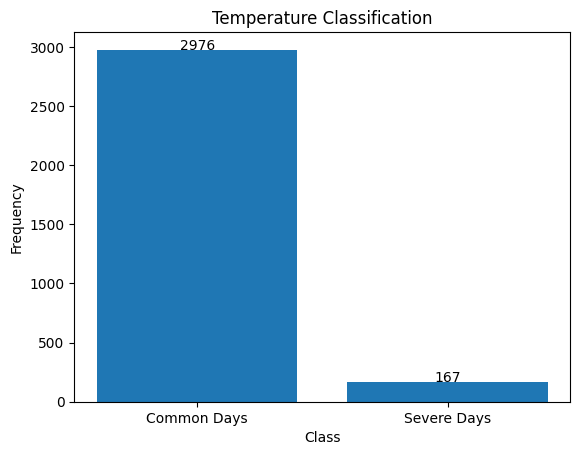

In [18]:
# Count the frequency of each class
class_counts = subsample_label_class['class_name'].value_counts()

# Plotting
plt.bar(class_counts.index, class_counts.values)

# Adding count labels on top of each bar
for index, value in enumerate(class_counts.values):
    plt.text(index, value, str(value), ha='center')
plt.title('Temperature Classification')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [19]:
subsample_feature_ = subsample_feature.drop(['date'], axis=1)
cls_xtrain, cls_xtest, cls_ytrain, cls_ytest = model_selection.train_test_split(subsample_feature_,
                                                                 subsample_label_class['class'].values,
                                                                 test_size=0.2,
                                                                 random_state=4)

In [20]:
scaled_cls_xtrain, scaled_cls_xtest = scale_data(cls_xtrain, cls_xtest)

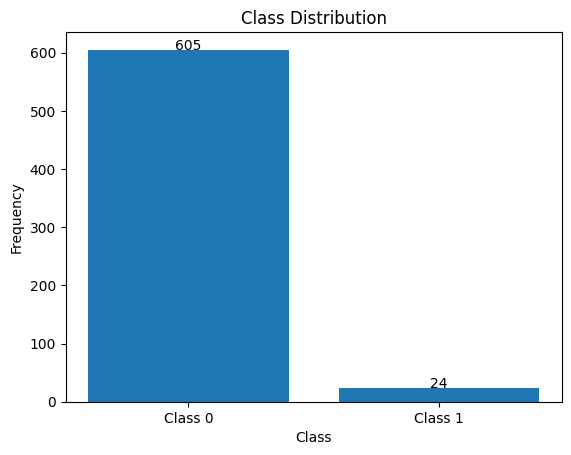

In [21]:
# Count the frequency of each class
class_counts = np.array([np.count_nonzero(cls_ytest == 0), np.count_nonzero(cls_ytest == 1)])
# Plotting

# Plotting for Random Over-Sampling data
plt.bar(['Class 0', 'Class 1'], class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
# Adding text labels on top of each bar
for index, value in enumerate(class_counts):
    plt.text(index, value, str(value), ha='center')

plt.show()

In [22]:
rf = RandomForestClassifier(n_estimators=50, max_depth=6, random_state=42)

Accuracy = 0.97 | Precision: 0.75 | Recall = 0.50 | F1_score = 0.60
POD = 0.50 | F: 0.01 | FAR = 0.25 | CSI = 0.43 | HSS = 0.59 | PSS = 0.49


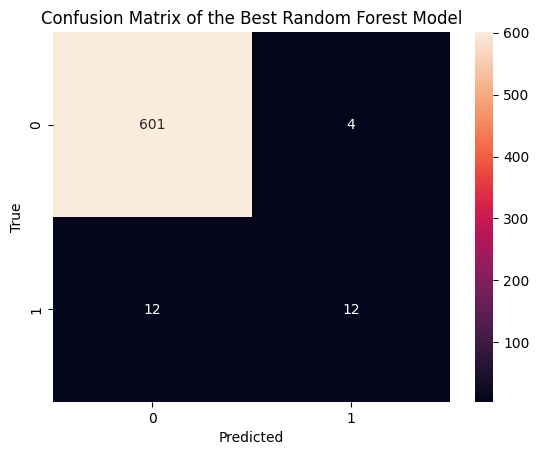

In [23]:
rf.fit(scaled_cls_xtrain, cls_ytrain)

# Make predictions on the test set
cls_y_pred = rf.predict(scaled_cls_xtest)

# Compute the confusion matrix
conf_matrix = confusion_matrix(cls_ytest, cls_y_pred)

results = evaluate_binary_classification(cls_ytest, cls_y_pred)
print(f"Accuracy = {results['accuracy']:.2f} | Precision: {results['precision']:.2f} | Recall = {results['recall']:.2f} | F1_score = {results['f1_score']:.2f}")

skr = evaluation_skill_metrics(cls_ytest, cls_y_pred)
print(f"POD = {skr['POD']:.2f} | F: {skr['F']:.2f} | FAR = {skr['FAR']:.2f} | CSI = {skr['CSI']:.2f} | HSS = {skr['HSS']:.2f} | PSS = {skr['PSS']:.2f}")

sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of the Best Random Forest Model')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-16-a8a29d135972>:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes_object[1].set_yticklabels(new_ticks)


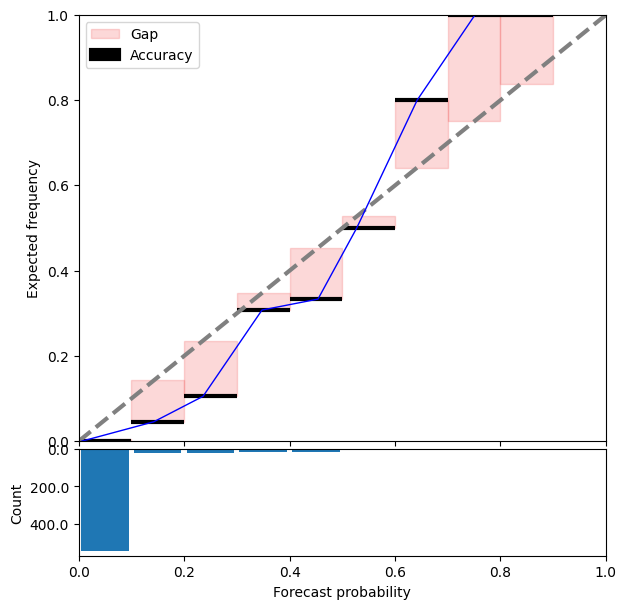

In [24]:
cls_ytest_probs = rf.predict_proba(scaled_cls_xtest)[:, 1]
reliability_diagram(cls_ytest, cls_ytest_probs)

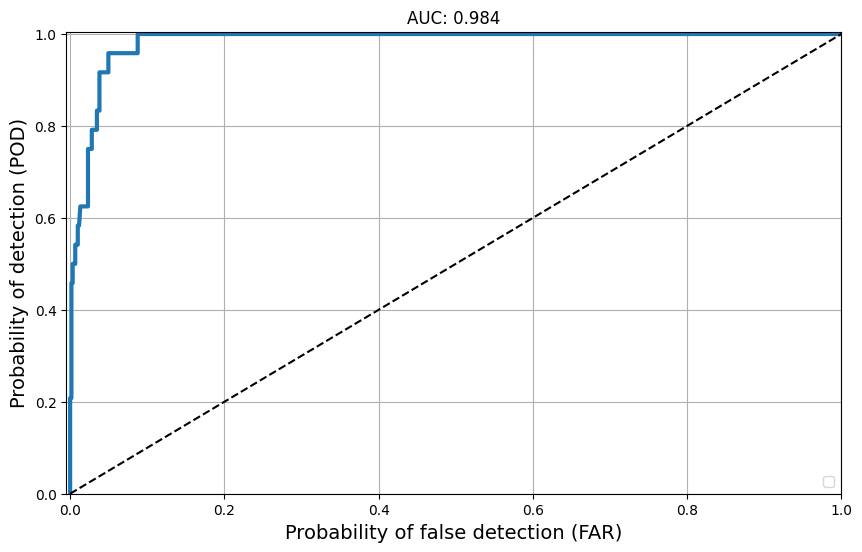

In [25]:
roc_curve(cls_ytest, cls_ytest_probs)

# How to overcome issues with model learning

### Cross-Validation

Cross-validation technique works by training with certain parts of the training dataset and holding out other parts as validation.

By the end of the process, one has k different results on k different validation sets. This allows you to assess how sensitive your model is to the training data used.

There is a ``standard k-fold'' cross validation method (left plot below) and variants of it. One variant is illustrated below on the right.

#### concept of window sets (right plot below)

A model is trained till a particular date and tested on the future dates iteratively such that the training window keeps increasingly shifting by specific time scale.

<figure>
    <p align="center">
        <img src="https://www.researchgate.net/profile/Rayan-H-Assaad/publication/355889701/figure/fig1/AS:1086138706071552@1635967055039/Classical-k-fold-cross-validation-vs-time-series-split-cross-validation.ppm" alt="Alt text for the image"/>
        <figcaption>Standard K-Fold Cross Validation vs Timeseries. Figure Credit: <a href="https://www.researchgate.net/figure/Classical-k-fold-cross-validation-vs-time-series-split-cross-validation_fig1_355889701">Link</a></figcaption>
    </p>
</figure>

# What to do if you have high training error and/or high validation / cross validation error?

Some suggestions below:

<figure>
    <p align="center">
        <img src="https://zahidhasan.github.io/images/bias_variance7.png" alt="Alt text for the image" width="800px" />
        <figcaption> Bias-Variance Trade-off. Figure Credit: <a href="https://zahidhasan.github.io/2020/10/13/bias-variance-trade-off-and-learning-curve.html">Link</a></figcaption>
    </p>
</figure>

# Some suggestions on interpreting your learning curves

<figure>
    <p align="center">
        <img src="https://zahidhasan.github.io/images/learning_curve2.png" alt="Alt text for the image" width="800px" />
    </p>
</figure>


**High Bias**

**- When training and testing errors converge and are both high**
- No matter how much data we feed the model, the model cannot represent the underlying relationship and has high systematic error
- Poor fit

**- Possible solutions:**

- Use more input features
- Increase model parameters (e.g., more hidden layer neurons, more layers)
- Decrease regularization (e.g., remove dropout, batch norm)


<figure>
    <p align="center">
        <img src="https://zahidhasan.github.io/images/learning_curve4.png" alt="Alt text for the image" width="800px" />
        <figcaption> Bias-Variance Trade-off. Figure Credit: <a href="https://zahidhasan.github.io/2020/10/13/bias-variance-trade-off-and-learning-curve.html">Link</a></figcaption>
    </p>
</figure>

**High Variance**

**- When there is a large gap between the training and validation errors**
- Poor generalization

**- Possible solutions:**

- more training data
- reduce number or complexity of features, manually or using a model selection algorithm or with dimensionality reduction
- increase regularization


# Boostrapping section

In class, we discussed the concept of bootstrapping for uncertainty quantification and/or hypothesis testing. Below are some code tidbits, but for more information, including types of bootstrapping, please see this [blogpost](https://blogs.sas.com/content/iml/2018/12/12/essential-guide-bootstrapping-sas.html) and this [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html).

In [26]:
import scipy

In [27]:
# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

In [28]:
dataset.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [40]:
# lets see how bootstrapping can help us create population statistics
future_samples = dataset["TOTAL"][200:]
past_samples = dataset["TOTAL"][:200]

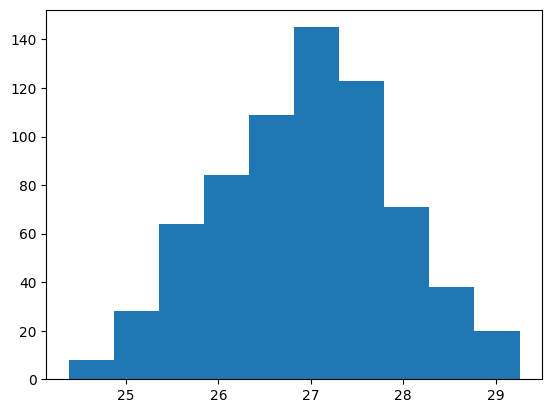

In [42]:
# the future population
plt.hist(future_samples)
plt.show()

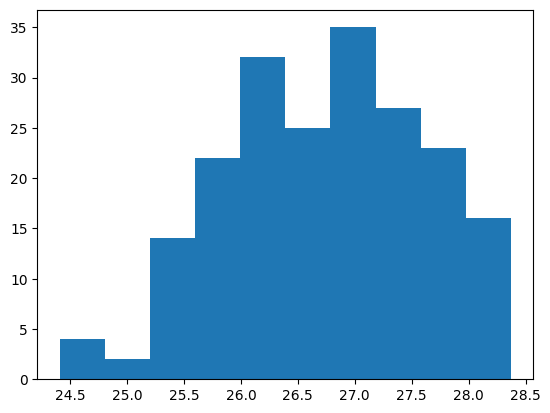

In [43]:
# the past population
plt.hist(past_samples)
plt.show()

In [44]:
# we can bootstrap the past population's mean to see if it ends up similar to the future population mean
boot_res = scipy.stats.bootstrap((past_samples.values,), np.mean, confidence_level=0.9, random_state=0)

In [46]:
# what is the total population mean?
past_samples.mean()

26.74255

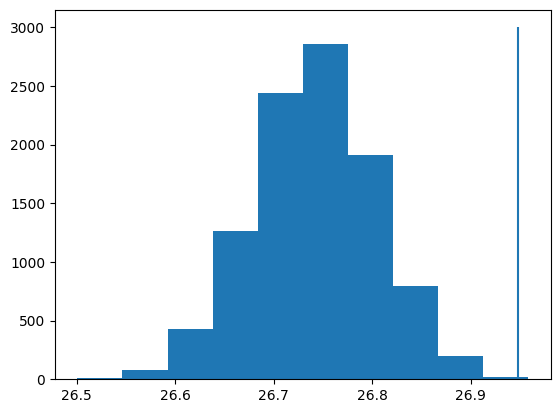

In [47]:
# what is the mean according to our bootstrap?
plt.hist(boot_res.bootstrap_distribution)
# does the bootstrap means characterize the population mean?
plt.vlines(future_samples.mean(), 0, 3000)
plt.show()

In [48]:
boot_res.confidence_interval

ConfidenceInterval(low=26.639905146314355, high=26.845881027024603)